In [134]:
import os
import urllib.request
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from data_cleaning import data_cleaner_and_manipulator

## Acquire data functions

In [95]:
def fetch_housing_data(housing_url, housing_path):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path,'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [6]:
fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH)

In [7]:
df = load_housing_data(housing_path = HOUSING_PATH)

## Data Analysis

In [12]:
# First of all we take a look at some instances of the data
df.head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   
5    -122.25     37.85                52.0        919.0           213.0   
6    -122.25     37.84                52.0       2535.0           489.0   
7    -122.25     37.84                52.0       3104.0           687.0   
8    -122.26     37.84                42.0       2555.0           665.0   
9    -122.25     37.84                52.0       3549.0           707.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
5       413.0       193.0         4.0368            269700.0        NEAR BAY  
6      1094.0       514.0         3.6591            299200.0        NEAR BAY  
7      1157.0       647.0         3.1200            241400.0        NEAR BAY  
8      1206.0       595.0         2.0804            226700.0        NEAR BAY  
9      1551.0       714.0         3.6912            261100.0        NEAR BAY

In [14]:
# We look how many instances there are in each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
# Then we take a look at some statiscal values
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

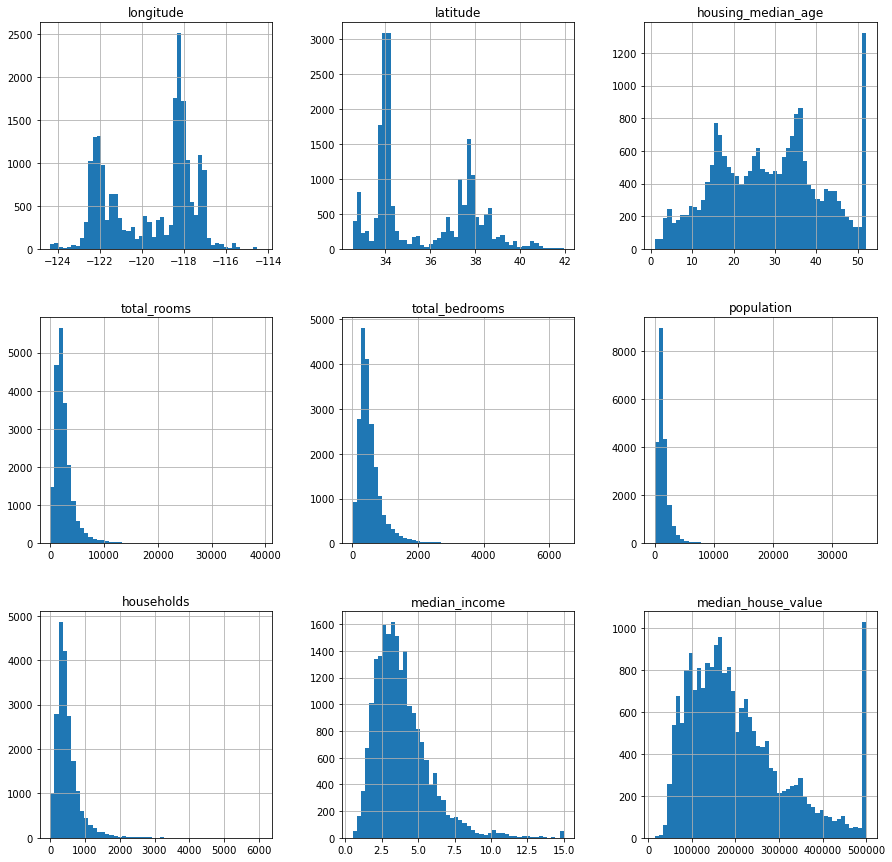

In [18]:
df.hist(bins=50,figsize=[15,15])
plt.show()

## Some insights from this first analysis:
- The features are tail-heavy, i.e., the instances lag to the right
- The features has scales that are too different from each other
- The median income are limited to the 0.5 and 15
- The housing_median_age feature in limited to 1 and 52
- The housing_median_value feature is limited to 500001.00

We now verify how correlated are the features with the target value (housing_median_value)
Note that corr() method only computes the linear correlation

<AxesSubplot:>

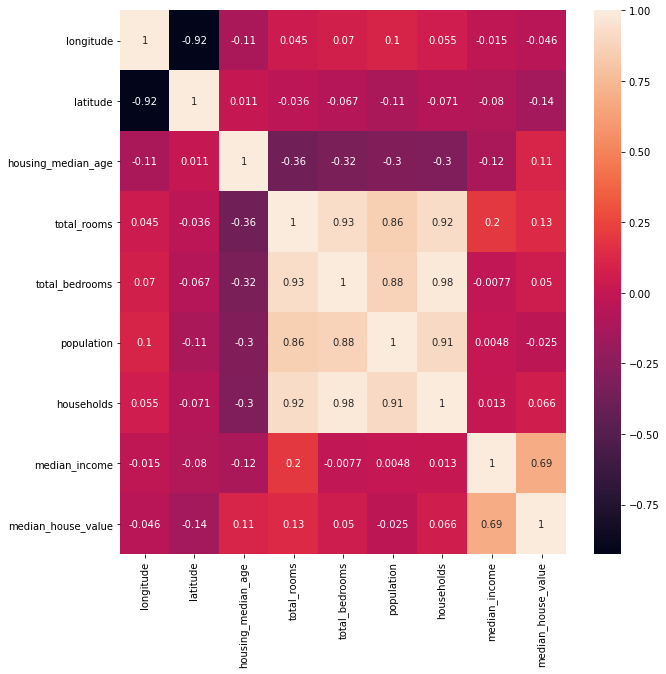

In [92]:
cor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot=True)

## Data Splitting

We can see that the median_income has a great correlation with our target feature, which is the median_house_value. Therefore, we might use this information in the sampling process carried out through the data splitting.


In [42]:
# Once the correlation between these two features are very high, 
# we do not want to lose this information while splitting the data. 
# Therefore we categorize this linear feature, and we use in the sklearn.model_selectio.StratifiedShuffleSplit
# instead of using sklearn.model_selection.train_test_split
df['income_cat'] = pd.cut(  df['median_income'], bins = [0, 1.5, 3., 4.5, 6, np.inf], 
                            labels = [1, 2, 3, 4,5])
df.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  income_cat  
0          5  
1          5  
2          5  
3          4  
4          3

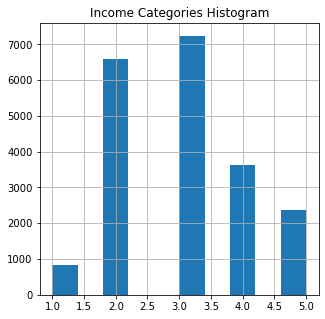

In [53]:
df['income_cat'].hist(figsize=(5,5))
plt.title('Income Categories Histogram')
plt.show()

In [56]:
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state= 42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set  = df.loc[test_index]

In [64]:
# We can see that the strat_train_set and stat_test_set keep the same proportions of the income_cat
pd.DataFrame({  'Train Set': strat_train_set['income_cat'].value_counts()/len(strat_train_set),
                'Test Set': strat_test_set['income_cat'].value_counts()/len(strat_test_set),
                'Original dataset': df['income_cat'].value_counts()/len(df)})

Train Set  Test Set  Original dataset
3   0.350594  0.350533          0.350581
2   0.318859  0.318798          0.318847
4   0.176296  0.176357          0.176308
5   0.114402  0.114583          0.114438
1   0.039850  0.039729          0.039826

In [68]:
# Now we can drop the income_cat column on both train and test sets
for set_ in (strat_train_set, strat_test_set):
    if 'income_cat' in set_.columns:
        set_.drop('income_cat', axis = 1, inplace = True)

## Data Visualization

housing = strat_train_set.copy()

In [69]:
housing = strat_train_set.copy()

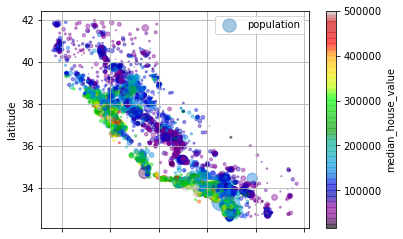

In [73]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
             s = housing['population']/100, label = 'population',
             c = 'median_house_value', cmap = plt.get_cmap('nipy_spectral'))
plt.grid(which = 'major')

In [78]:
housing['population'].describe()

count    16512.000000
mean      1419.790819
std       1115.686241
min          3.000000
25%        784.000000
50%       1164.000000
75%       1719.250000
max      35682.000000
Name: population, dtype: float64

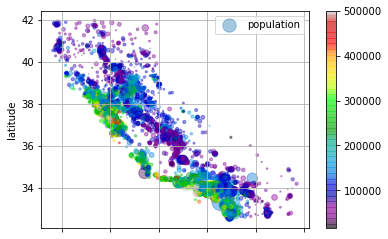

In [84]:
housing.plot(kind = "scatter", x = 'longitude', y = 'latitude', alpha = .4,
             s = housing['population']/100, label = 'population',
             c = housing['median_house_value'], cmap = plt.get_cmap('nipy_spectral'))
plt.grid()             

## Data Engineering
Here we create new features

<AxesSubplot:>

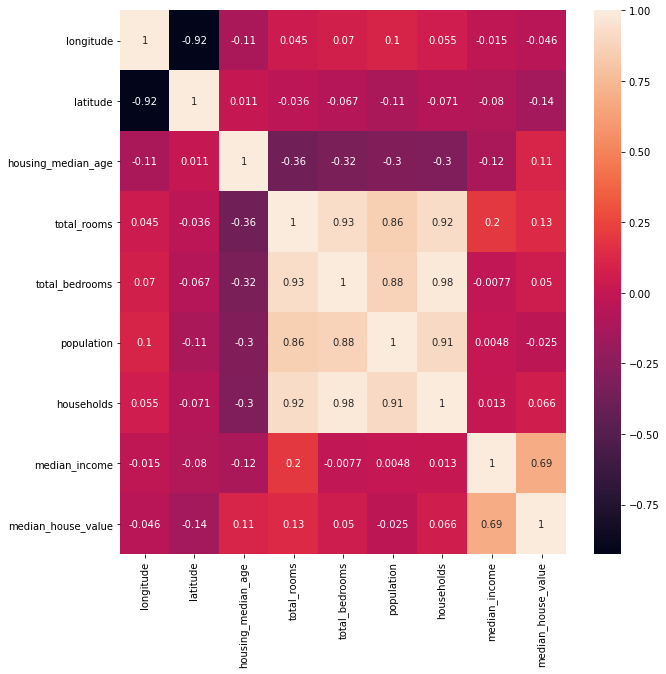

In [87]:
# Once again we take a look at the correlation map
cor = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, annot = True)

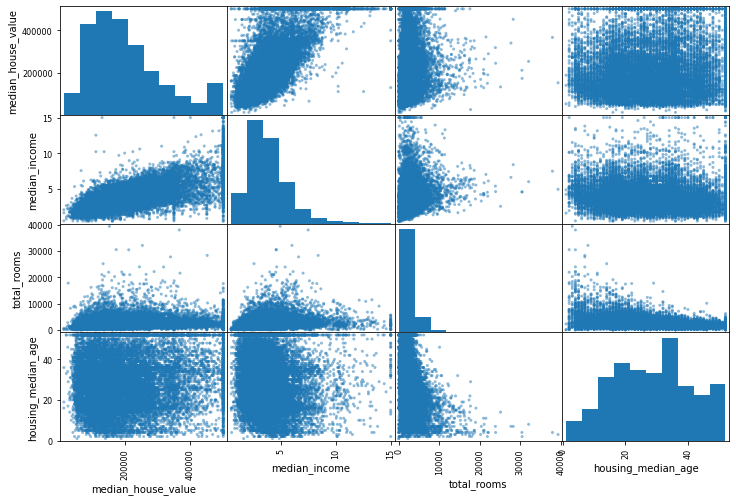

In [102]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing[attributes], figsize = (12,8), grid=True)
plt.show()

We can see a high correlation between median income (median_income) and the target feature (median_house_valeu)

Also, the price limit is observable, being limited to 500000. Also we see that there are some horizontal lines in the plot, in ~350000, ~450000

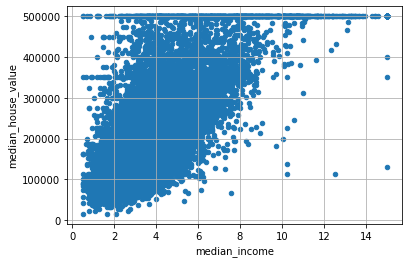

In [112]:
housing.plot(kind = 'scatter', y = 'median_house_value', x = 'median_income')
plt.grid()
plt.show()

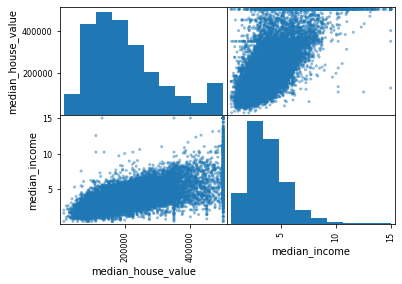

In [109]:
pd.plotting.scatter_matrix(housing[['median_house_value', 'median_income']], diagonal='hist')
plt.show()

We can see a high correlation between
- household and the total_bedrooms features
- total_rooms and total_bedrooms features
- population and households

Therefore, we create new features based on this information.
Also, the number of rooms in the region has no value without the number of households in that region. The relation between the size of the population and number of households is also valueble. Finally the relation between the number of bedrooms is way more valuable when we devide it by the total number of rooms.


In [90]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [91]:
cor = housing.corr()
cor['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Data cleaning

1) Break the dataset into the features X and the label y

In [130]:
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value']

2) Dealing with the NaN values imputing the mean

In [139]:
housing_NaN, housing_mean = data_cleaner_and_manipulator.treat_NaN(df = housing, type = 'fillna_mean')
housing_NaN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


Manipulating text and categorical data

In [145]:
list(housing.select_dtypes(include=['object']).columns)

['ocean_proximity']

In [117]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16354 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_room         16354 non-null  float64
 12  population_per_household  16512 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.8+ MB


In [116]:
housing.dropna(subset=None)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
...          ...       ...                 ...          ...             ...   
6563     -118.13     34.20                46.0       1271.0           236.0   
12053    -117.56     33.88                40.0       1196.0           294.0   
13908    -116.40     34.09                 9.0       4855.0           872.0   
11159    -118.01     33.82                31.0       1960.0           380.0   
15775    -122.45     37.77                52.0       3095.0           682.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   
...           ...         ...            ...                 ...   
6563        573.0       210.0         4.9312            240200.0   
12053      1052.0       258.0         2.0682            113000.0   
13908      2098.0       765.0         3.2723             97800.0   
11159      1356.0       356.0         4.0625            225900.0   
15775      1269.0       639.0         3.5750            500001.0   

      ocean_proximity  rooms_per_household  bedrooms_per_room  \
17606       <1H OCEAN             4.625369           0.223852   
18632       <1H OCEAN             6.008850           0.159057   
14650      NEAR OCEAN             4.225108           0.241291   
3230           INLAND             5.232295           0.200866   
3555        <1H OCEAN             4.505810           0.231341   
...               ...                  ...                ...   
6563           INLAND             6.052381           0.185681   
12053          INLAND             4.635659           0.245819   
13908          INLAND             6.346405           0.179609   
11159       <1H OCEAN             5.505618           0.193878   
15775        NEAR BAY             4.843505           0.220355   

       population_per_household  
17606                  2.094395  
18632                  2.707965  
14650                  2.025974  
3230                   4.135977  
3555                   3.047847  
...                         ...  
6563                   2.728571  
12053                  4.077519  
13908                  2.742484  
11159                  3.808989  
15775                  1.985915  

[16354 rows x 13 columns]